###Mount drive to import datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout, Conv1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import gensim
import time

from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

###Functions

In [ ]:
def quickHistogram(labels, classes = ["other", "tech"]): 
  counts = []

  for i in range(len(classes)):
    count = 0
    for j in labels:
      if j == i:
        count += 1
    counts.append(count)

  plt.bar(classes, counts)
  plt.show()

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from itertools import chain

def compareContent (base, new):

  #flatten list of lists
  base = chain.from_iterable(base)
  new = chain.from_iterable(new)

  #eliminate repeated words from counting
  baseSet = set(base)
  newSet = set(new)

  jointSet = baseSet.intersection(newSet)
  similarity = (len(jointSet)/len(baseSet))*100
  print ("{:.2f}".format(similarity) + '%' )


In [ ]:
import string

def clean_text(text): 
  if pd.isna(text) == False:
    delete_dict = {sp_character: ' ' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower().split(' ')

In [ ]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    #labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Datasets

In [ ]:
dataMCTI = pd.read_excel("Datasets/oportunidades_classificacao_4.xlsx", sheet_name='Oportunidades')

dataPPF = pd.read_excel("Datasets/db_PPF_validacao_para UNB_ FINAL.xlsx", sheet_name='Oportunidades')

In [ ]:
print("MCTI Dataset has " + str(dataMCTI.shape[0]) + " examples with " + str(dataMCTI.shape[1]) + " columns of information")

print("PPF Dataset has " + str(dataPPF.shape[0]) + " examples with " + str(dataPPF.shape[1]) + " columns of information")

MCTI Dataset has 357 examples with 11 columns of information
PPF Dataset has 519 examples with 13 columns of information


In [ ]:
dataPPF_new = dataPPF.copy()
dataPPF_new = dataPPF_new.drop(columns=['html','houve mudança na classificação?'])

#TODO: IDENTIFY AND REMOVE NULL DATA IN OPO_TEXTO
#dataPPF_new.replace("", float("NaN"), inplace=True)
#dataPPF_new.dropna(subset = ['opo_texto'], inplace=True

In [ ]:
concated = pd.concat([dataMCTI, dataPPF_new])

In [ ]:
newdata = dataMCTI.copy()
newdata = newdata[(newdata['clas'] == 'Y') | (newdata['clas'] == 'N')]
sentencesMCTI = newdata['opo_texto']
labels = newdata['clas']
labelsMCTI = np.where(labels == "Y", 1, 0)

In [ ]:
sentencesMCTIList = newdata['opo_texto'].apply(clean_text)
sentencesMCTIList = sentencesMCTIList.tolist()

In [ ]:
newdata = dataPPF.copy()
newdata = newdata[(newdata['clas'] == 'Y') | (newdata['clas'] == 'y') | (newdata['clas'] == 'N')]
sentencesPPF = newdata['opo_texto']
labels = newdata['clas']
labelsPPF = np.where(((labels == "Y") | (labels == "y")), 1, 0)

In [ ]:
sentencesPPFList = newdata['opo_texto'].apply(clean_text)
sentencesPPFList = sentencesPPFList.tolist()

In [ ]:
newdata = dataMCTI.copy()
newdata = newdata[(newdata['clas'] != 'Y') & (newdata['clas'] != 'N')]
complSentencesMCTI = newdata['opo_texto']

newdata = dataPPF.copy()
newdata = newdata[(newdata['clas'] != 'Y') & (newdata['clas'] != 'y') & (newdata['clas'] != 'N')]
complSentencesPPF = newdata['opo_texto']

del newdata

In [ ]:
complSentencesMCTIList = complSentencesMCTI.apply(clean_text)
complSentencesMCTIList = complSentencesMCTIList.tolist()

complSentencesPPFList = complSentencesPPF.apply(clean_text)
complSentencesPPFList = complSentencesPPFList.tolist()

#WORD2VEC MODEL#

In [ ]:
#initialise callback class
class callback(CallbackAny2Vec):
  """
  Print the loss value after each epoch
  """
  def __init__(self):
    self.epoch = 0
    #gensim loss is cumulative, so we record previous values to print
    self.loss_previous_step = 0 

  def on_epoch_end(self, model):
    loss = model.get_latest_training_loss()
    if self.epoch % 100 == 0:
      print('Loss after epoch {}: {}'.format(self.epoch, loss-self.loss_previous_step))

    self.epoch+= 1
    self.loss_previous_step = loss

In [ ]:
#create full word embedding list MCTI + PPF
newdata = concated.copy()
newdata = newdata[(newdata['clas'] == 'Y') | (newdata['clas'] == 'y') | (newdata['clas'] == 'N')]
sentencesList = newdata['opo_texto'].apply(clean_text)
sentencesList = sentencesList.tolist()

In [ ]:
#initialise word2vec class
w2v_model = Word2Vec(size=300,
                     window = 15,
                     min_count = 1,
                     workers = 20,
                     sg = 1,
                     negative = 5,
                     sample = 1e-5)

#build vocab
w2v_model.build_vocab(sentencesList) 

#train the model
start = time.time()
w2v_model.train(sentencesList,
                total_examples=w2v_model.corpus_count,
                epochs = 1001,
                report_delay = 1,
                compute_loss = True,
                callbacks=[callback()])
end = time.time()

print("elapsed time in seconds: "+str(end-start))
w2v_model.save('/content/drive/MyDrive/Mestrado/word2vec_mcti_ppf.model')

Loss after epoch 0: 224167.734375
Loss after epoch 100: 61399.0
Loss after epoch 200: 57837.0
Loss after epoch 300: 44606.0
Loss after epoch 400: 44614.0


KeyboardInterrupt: ignored

###Load model###

In [ ]:
reloaded_w2v_model = Word2Vec.load('/content/drive/MyDrive/Mestrado/word2vec_mcti_ppf.model')
words = list(reloaded_w2v_model.wv.vocab)

In [ ]:
x_vals, y_vals, labels = reduce_dimensions(reloaded_w2v_model)

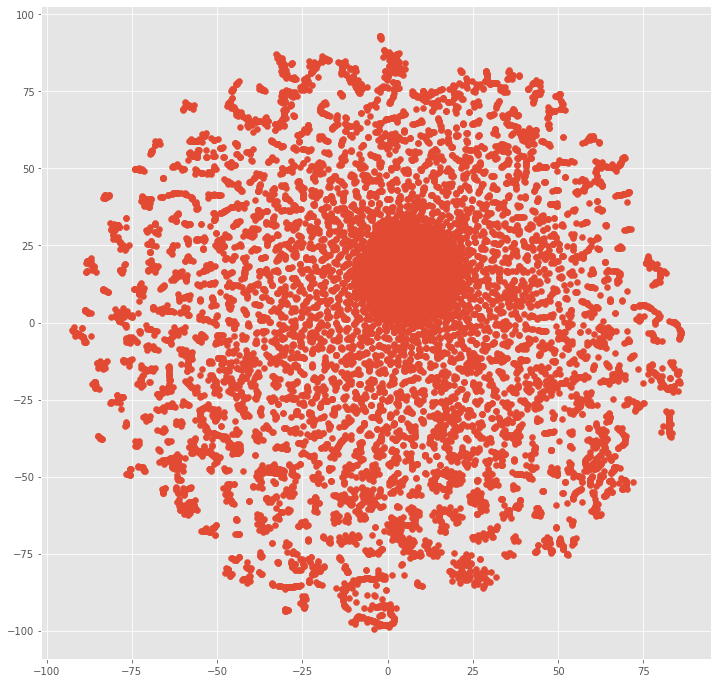

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)

#Training the network#

In [ ]:
mapped_words = []
for word in words:
  mapped_words.append(reloaded_w2v_model.wv[word])

In [ ]:
# create training testing data

MCTIinput_vector = []
for sentence in sentencesMCTIList:
  aux_vector = []
  for word in sentence:
    aux_vector.append(reloaded_w2v_model.wv[word])
  MCTIinput_vector.append(aux_vector)

sentences_lengths = []
for sentence in sentencesMCTIList:
  sentences_lengths.append(len(sentence))

print(np.shape(MCTIinput_vector))

max_sizeMCTI = 0
count_larger_than_4096 = 0
count_larger_than_512 = 0
for sentence in MCTIinput_vector:
  if len(sentence) > max_sizeMCTI:
    max_sizeMCTI = len(sentence)
  if (len(sentence) > 512):
    count_larger_than_512 +=  1
  if (len(sentence) > 4096):
    count_larger_than_4096 +=1

print(count_larger_than_512)
print(count_larger_than_4096)
  

lengthMCTI = max_sizeMCTI
MCTIinput_vector = pad_sequences(MCTIinput_vector, maxlen=lengthMCTI, padding='pre')

print(np.shape(MCTIinput_vector))

#MCTI
x_trainMCTI, x_testMCTI, y_trainMCTI, y_testMCTI = train_test_split(MCTIinput_vector, labelsMCTI, test_size=0.20, random_state=20)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(260,)
99
8
(260, 4293, 300)


In [ ]:
print(lengthMCTI)

4293


Text(0.5, 1.0, 'Number of words per text - distribution')

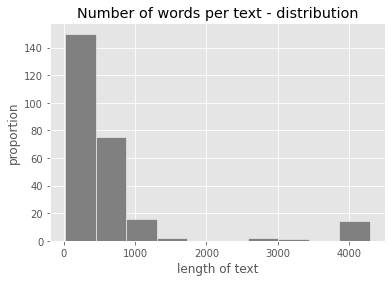

In [ ]:
sent_len = [i for i in sentences_lengths if i!=0]


plt.hist(sent_len, color="gray", ec="white")
plt.xlabel("length of text")
plt.ylabel("proportion")
plt.title("Number of words per text - distribution")

###NN###

In [ ]:
mcti_NN_Model = Sequential()
mcti_NN_Model.add(Input(shape=np.shape(MCTIinput_vector[0])))
mcti_NN_Model.add(Flatten())
mcti_NN_Model.add(Dense(1, activation='sigmoid'))

#keras.utils.plot_model(mcti_NN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf NN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_NN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_NN_MCTI = mcti_NN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
loss, accuracy, f1_score, precision, recall = mcti_NN_Model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5529 - f1_m: 0.5655 - precision_m: 0.6872 - recall_m: 0.4959
Epoch 1: val_accuracy improved from -inf to 0.82692, saving model to best weights mcti ppf NN.h5
2/2 [==============================] - 3s 940ms/step - loss: 0.6874 - accuracy: 0.5529 - f1_m: 0.5655 - precision_m: 0.6872 - recall_m: 0.4959 - val_loss: 0.6586 - val_accuracy: 0.8269 - val_f1_m: 0.8696 - val_precision_m: 0.8571 - val_recall_m: 0.8824
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000
Epoch 2: val_accuracy did not improve from 0.82692
2/2 [==============================] - 1s 533ms/step - loss: 0.3697 - accuracy: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.6208 - val_accuracy: 0.7885 - val_f1_m: 0.8571 - val_precision_m: 0.7674 - val_recall_m: 0.9706
Epoch 3/100
2/2 [==============================]

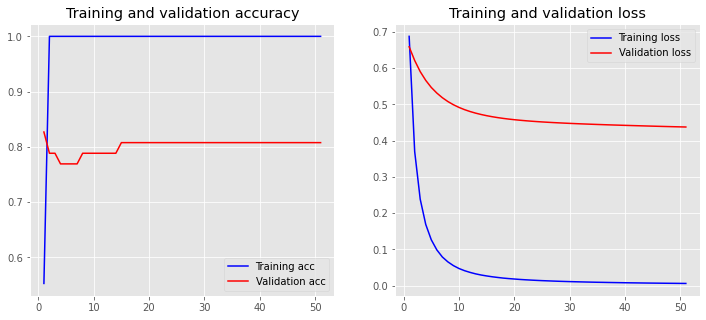

In [ ]:
plot_history(history_NN_MCTI)

In [ ]:
reconstructed_model_NN = keras.models.load_model("best weights mcti ppf NN.h5", 
                                                 custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_NN.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))


Accuracy: 82.692307
f1_score: 85.454541
precision: 83.916086
recall: 87.121212


###DNN###

In [ ]:
mcti_DNN_Model = Sequential()
mcti_DNN_Model.add(Dense(512, input_shape=np.shape(MCTIinput_vector[0])))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(256))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(128))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Flatten())
mcti_DNN_Model.add(Dense(1, activation='sigmoid'))

#keras.utils.plot_model(mcti_DNN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf DNN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
callbacks_list = [checkpoint, earlystop]

mcti_DNN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_DNN_MCTI = mcti_DNN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
# loss, accuracy, f1_score, precision, recall = mcti_DNN_Model.evaluate(x_testMCTI, y_testMCTI, verbose=0)
# print('Accuracy: %f' % (accuracy*100))

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5481 - f1_m: 0.6354 - precision_m: 0.5916 - recall_m: 0.6902
Epoch 1: val_accuracy improved from -inf to 0.65385, saving model to best weights mcti ppf DNN.h5
2/2 [==============================] - 3s 862ms/step - loss: 0.6871 - accuracy: 0.5481 - f1_m: 0.6354 - precision_m: 0.5916 - recall_m: 0.6902 - val_loss: 0.6395 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.6587 - f1_m: 0.7632 - precision_m: 0.6173 - recall_m: 1.0000
Epoch 2: val_accuracy did not improve from 0.65385
2/2 [==============================] - 1s 470ms/step - loss: 0.5720 - accuracy: 0.6587 - f1_m: 0.7632 - precision_m: 0.6173 - recall_m: 1.0000 - val_loss: 0.6655 - val_accuracy: 0.6346 - val_f1_m: 0.6780 - val_precision_m: 0.8000 - val_recall_m: 0.5882
Epoch 3/100
2/2 [==============================

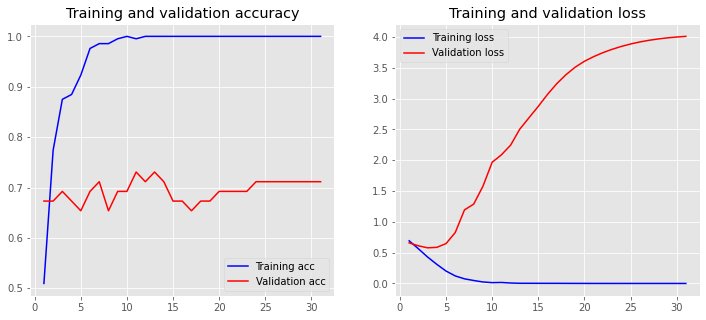

In [ ]:
plot_history(history_DNN_MCTI)

In [ ]:
reconstructed_model = keras.models.load_model("best weights mcti ppf DNN2.h5", custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))


Accuracy: 71.153843
f1_score: 77.936500
precision: 72.554350
recall: 84.848487


###CNN###

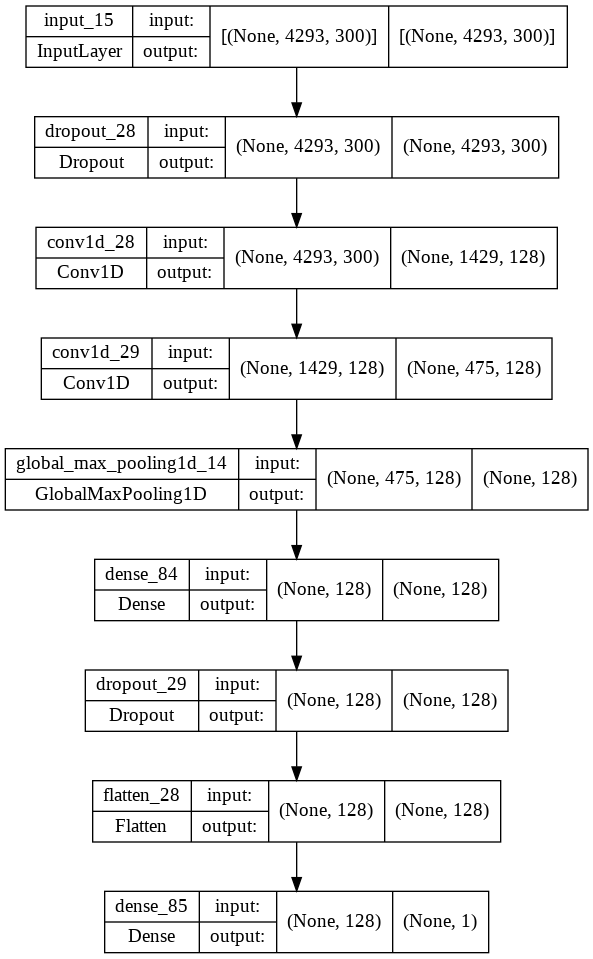

In [ ]:
mcti_CNN_Model = Sequential()
mcti_CNN_Model.add(Input(shape=np.shape(MCTIinput_vector[0])))
mcti_CNN_Model.add(Dropout(0.5))

# Conv1D + global max pooling
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
mcti_CNN_Model.add(Dense(128, activation="relu"))
mcti_CNN_Model.add(Dropout(0.5))

mcti_CNN_Model.add(Flatten())
mcti_CNN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_CNN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf CNN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_CNN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                       metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_CNN_MCTI = mcti_CNN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
loss, accuracy, f1_score, precision, recall = mcti_CNN_Model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5577 - f1_m: 0.6468 - precision_m: 0.5927 - recall_m: 0.7198
Epoch 1: val_accuracy improved from -inf to 0.65385, saving model to best weights mcti ppf CNN.h5
2/2 [==============================] - 2s 593ms/step - loss: 0.6874 - accuracy: 0.5577 - f1_m: 0.6468 - precision_m: 0.5927 - recall_m: 0.7198 - val_loss: 0.6514 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.5721 - f1_m: 0.7304 - precision_m: 0.5783 - recall_m: 0.9928
Epoch 2: val_accuracy did not improve from 0.65385
2/2 [==============================] - 1s 401ms/step - loss: 0.6689 - accuracy: 0.5721 - f1_m: 0.7304 - precision_m: 0.5783 - recall_m: 0.9928 - val_loss: 0.6414 - val_accuracy: 0.6538 - val_f1_m: 0.7907 - val_precision_m: 0.6538 - val_recall_m: 1.0000
Epoch 3/100
2/2 [==============================

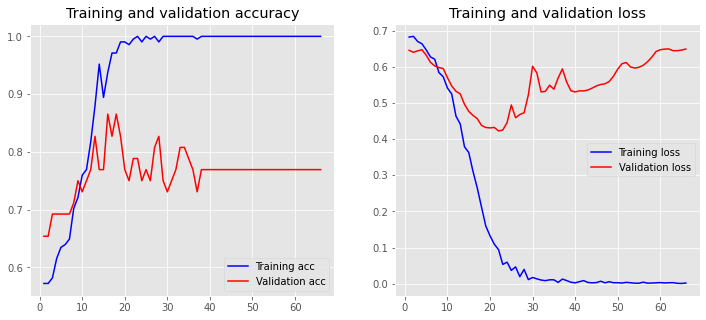

In [ ]:
plot_history(history_CNN_MCTI)

In [ ]:
reconstructed_model = keras.models.load_model("best weights mcti ppf CNN3.h5", custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Accuracy: 86.538464
f1_score: 90.834689
precision: 84.857142
recall: 97.727275


###LSTM###

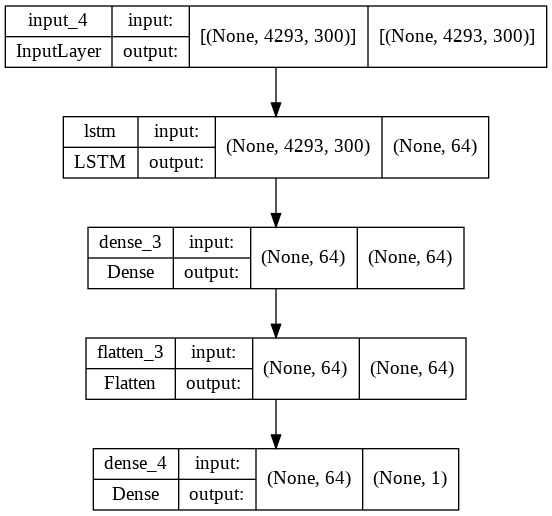

In [ ]:
mcti_LSTM_Model = Sequential()
mcti_LSTM_Model.add(Input(shape=np.shape(MCTIinput_vector[0])))
mcti_LSTM_Model.add(LSTM(64))
mcti_LSTM_Model.add(Dense(64, activation='relu'))
mcti_LSTM_Model.add(Flatten())
mcti_LSTM_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_LSTM_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf LSTM.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_LSTM_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_LSTM_MCTI = mcti_LSTM_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=128)

# evaluate the model
loss, accuracy, f1_score, precision, recall = mcti_NN_Model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.4712 - f1_m: 0.3903 - precision_m: 0.5727 - recall_m: 0.3169
Epoch 1: val_accuracy improved from -inf to 0.59615, saving model to best weights mcti ppf LSTM.h5
2/2 [==============================] - 4s 1s/step - loss: 0.6944 - accuracy: 0.4712 - f1_m: 0.3903 - precision_m: 0.5727 - recall_m: 0.3169 - val_loss: 0.6891 - val_accuracy: 0.5962 - val_f1_m: 0.6957 - val_precision_m: 0.6857 - val_recall_m: 0.7059
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.7115 - f1_m: 0.7693 - precision_m: 0.7222 - recall_m: 0.8272
Epoch 2: val_accuracy improved from 0.59615 to 0.63462, saving model to best weights mcti ppf LSTM.h5
2/2 [==============================] - 1s 593ms/step - loss: 0.6852 - accuracy: 0.7115 - f1_m: 0.7693 - precision_m: 0.7222 - recall_m: 0.8272 - val_loss: 0.6830 - val_accuracy: 0.6346 - val_f1_m: 0.7397 - val_precision_m: 0.6923 - val_recall_m: 0.794

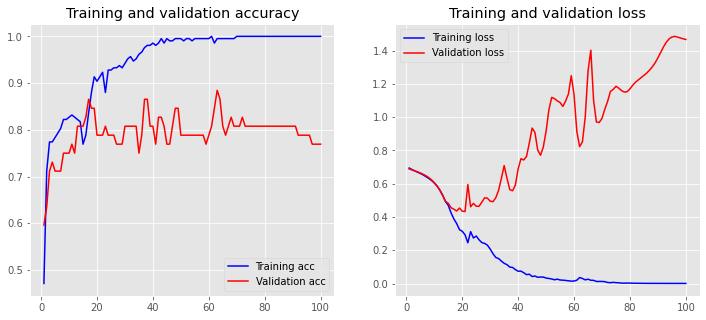

In [ ]:
plot_history(history_LSTM_MCTI)

In [ ]:
reconstructed_model_LSTM = keras.models.load_model("best weights mcti ppf LSTM.h5", 
                                                   custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model_LSTM.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Accuracy: 88.461536
f1_score: 91.391933
precision: 90.357143
recall: 93.181819
